In [ ]:
import os

os.environ["OPENAI_API_KEY"]=""
os.environ["GOOGLE_API_KEY"] = ""
os.environ["GROQ_API_KEY"] = ""

In [ ]:
import sugardata as su
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from transformers import (
    pipeline,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)


DATASET

In [3]:
DATASET = "zeroshot/twitter-financial-news-sentiment"

In [4]:
ds = load_dataset(DATASET)
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})


In [ ]:
# Convert the dataset to a format suitable for training

combined = concatenate_datasets([ds["train"], ds["validation"]])
combined = combined.shuffle(seed=42)
split1 = combined.train_test_split(test_size=0.3, seed=42)
split2 = split1["test"].train_test_split(test_size=0.5, seed=42)
ds = DatasetDict({
    "train":       split1["train"],   # 70%
    "test":        split2["train"],   # 15%
    "validation":  split2["test"]     # 15%
})

print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8351
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1790
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1790
    })
})


Counts DataFrame:
    train  test  validation
0   1267   252         270
1   1652   403         343
2   5432  1135        1177


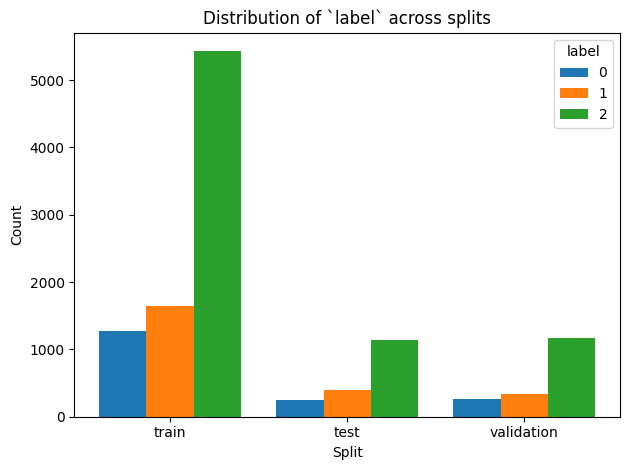

In [ ]:
def plot_feature_distribution(ds, feature_name: str):
    # 1) Collect value‐counts for each split
    counts = {}
    all_categories = set()
    for split_name, split in ds.items():
        df = split.to_pandas()
        vc = df[feature_name].value_counts()
        counts[split_name] = vc
        all_categories.update(vc.index.tolist())
    
    # 2) Build a DataFrame: rows=categories, cols=splits
    categories = sorted(all_categories)
    df_counts = pd.DataFrame(
        { split: counts[split].reindex(categories, fill_value=0)
          for split in counts },
        index=categories
    )

    print("Counts DataFrame:\n", df_counts)
    
    # 3) Transpose for plotting: rows=splits, cols=categories
    df_plot = df_counts.T
    
    # 4) Plot grouped bar chart with splits on x-axis
    x = np.arange(len(df_plot.index))
    n_categories = len(df_plot.columns)
    width = 0.8 / n_categories
    
    _, ax = plt.subplots()
    for i, category in enumerate(df_plot.columns):
        ax.bar(x + i * width, df_plot[category], width, label=category)
    
    ax.set_xticks(x + width * (n_categories - 1) / 2)
    ax.set_xticklabels(df_plot.index, rotation=0)
    ax.set_xlabel("Split")
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of `{feature_name}` across splits")
    ax.legend(title=feature_name)
    plt.tight_layout()
    plt.show()

plot_feature_distribution(ds, "label")

BASE MODEL

In [7]:
BASE_MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

In [8]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL)

# Access label mappings
LABEL2ID = model.config.label2id
ID2LABEL = model.config.id2label

print("label2id:", LABEL2ID)
print("id2label:", ID2LABEL)

label2id: {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}
id2label: {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}


In [9]:
base_pipe = pipeline("text-classification", model=BASE_MODEL, device=0)

pred_good = base_pipe("Good")
pred_bad = base_pipe("Bad")
pred_neutral = base_pipe("Neutral")

print(f"Positive prediction: {pred_good}")
print(f"Negative prediction: {pred_bad}")
print(f"Neutral prediction: {pred_neutral}")

Device set to use cuda:0


Positive prediction: [{'label': 'LABEL_2', 'score': 0.6097785830497742}]
Negative prediction: [{'label': 'LABEL_0', 'score': 0.495851069688797}]
Neutral prediction: [{'label': 'LABEL_1', 'score': 0.7306323647499084}]


In [10]:
MODEL_LABEL_MAPPING = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive",
    "Negative": "LABEL_0",
    "Neutral": "LABEL_1",
    "Positive": "LABEL_2",
}

DATASET_LABEL_MAPPING = {
    "Positive": 1,
    "Negative": 0,
    "Neutral": 2,
    0: "Negative",
    1: "Positive",
    2: "Neutral",
}

DATASET_LABELS = [
    ID2LABEL.get(0),
    ID2LABEL.get(1),
    ID2LABEL.get(2),
]

BASE MODEL EVALUATION

In [11]:
print(ds["train"][144])

def encode_labels(example):
    model_text_label =MODEL_LABEL_MAPPING.get(DATASET_LABEL_MAPPING.get(example['label']))
    example['label'] = LABEL2ID[model_text_label]
    return example

ds = ds.map(encode_labels)

print(ds["train"][144])

{'text': 'Edited Transcript of NHI earnings conference call or presentation 7-Nov-19 5:00pm GMT', 'label': 2}
{'text': 'Edited Transcript of NHI earnings conference call or presentation 7-Nov-19 5:00pm GMT', 'label': 1}


In [12]:
def evaluate_sentiment_model(
        pi: pipeline,
        data: Dataset,
        text_field: str,
        true_label_field: str,
        verbose: bool = True,
    ):
    y_true = []
    y_pred = []

    for idx, row in enumerate(data):
        text = row[text_field]
        if isinstance(text, str) and len(text) > 0:
            text = text.strip()
            text = text[:2000]

        pred = pi(text)[0]["label"]
        true = ID2LABEL[row[true_label_field]]
        y_true.append(true)
        y_pred.append(pred)

        if verbose and idx % 1000 == 0:
            print(f"Processed {idx} rows: {pred} vs {true}")
    
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_true, y_pred,labels=DATASET_LABELS)

    # Per-class F1 (optional, for analysis)
    f1_per_class = f1_score(y_true, y_pred, average=None)

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm,
        "f1_per_class_0": f1_per_class[0],
        "f1_per_class_1": f1_per_class[1],
        "f1_per_class_2": f1_per_class[2],
        
    }

base_test_evals = evaluate_sentiment_model(base_pipe, ds["test"], "text", "label")
print(base_test_evals)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed 0 rows: LABEL_2 vs LABEL_1
Processed 1000 rows: LABEL_1 vs LABEL_1
{'accuracy': 0.6798882681564246, 'f1_macro': 0.5789664814542795, 'f1_weighted': 0.6658192398692953, 'precision': 0.6704192531803708, 'recall': 0.6798882681564246, 'confusion_matrix': array([[114, 137,   1],
       [104, 943,  88],
       [  9, 234, 160]]), 'f1_per_class_0': np.float64(0.4759916492693111), 'f1_per_class_1': np.float64(0.7701102490812577), 'f1_per_class_2': np.float64(0.49079754601226994)}


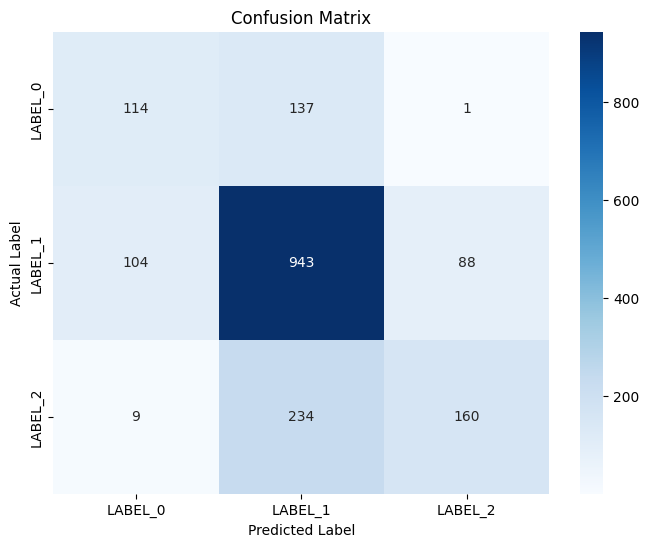

In [13]:
def plot_cm(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=DATASET_LABELS, yticklabels=DATASET_LABELS)

    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()


plot_cm(base_test_evals["confusion_matrix"])

In [14]:
def get_failed_instances(data, pipe, text_field, true_label_field):
    row_indices = []
    preds = []

    for idx, row in enumerate(data):
        text = row[text_field]
        if isinstance(text, str) and len(text) > 0:
            text = text.strip()
            text = text[:2000]

        pred = pipe(text)[0]["label"]
        true = ID2LABEL[row[true_label_field]]

        if pred != true:
            row_indices.append(idx)
            preds.append(LABEL2ID[pred])

    return row_indices, preds

failed_train_indices, failed_train_preds = get_failed_instances(ds["train"], base_pipe, "text", "label")
print(f"Number of failed instances: {len(failed_train_indices)}")

examples = []
for idx in failed_train_indices:
    examples.append(ds["train"][idx]["text"])

Number of failed instances: 2598


In [15]:
vendors = {
    "openai": "gpt-4o-mini",
    "gemini": "gemini-1.5-flash",
    #"groq": "llama-3.3-70b-versatile",
    #"ollama": "gemma3:27b",
    #"together": "mistralai/Mistral-7B-Instruct-v0.2"
}

new_data_dict = await su.augment_sentiment_multi_vendor_async(
    examples=examples,
    vendors=vendors,
    language="en",
    batch_size=16,
    label_options=["Positive", "Negative"],
    verbose=True,
)

Retrying abatch (attempt 1) due to: OutputParserException('Invalid json output: ```json\n{\n  "concept": "Household debt",\n  "aspects": [\n    "increase",\n    "Federal Reserve report"\n  ],\n  "writing_style": "Informative",\n  "medium": "Social media",\n  "persona": "News reporter",\n  "intention": "Inform",\n  "sentence_length": "Short",\n  "given_text": "Household debt jumps the most in 12 years, Federal Reserve report says\\xa0https://t.co/kmqxVS6co3"\n}\n```\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE ')
Retrying abatch (attempt 1) due to: OutputParserException('Failed to parse SentimentStructure from completion {"concept": null, "aspects": ["general"], "writing_style": "informal", "medium": "social media", "persona": "casual", "intention": "sharing a link", "sentence_length": "short", "given_text": "Wow  https://t.co/L9mDvwlyhx"}. Got: 1 validation error for SentimentStructure\nconcept\n  Input should be a valid s

In [30]:
print(new_data_dict["gemini"][10])

{'generated_text': "Tapestry's Q2 earnings per share soared, hitting $1.08—a significant jump from last year's 88 cents. This robust financial performance showcases a truly stellar quarterly result, exceeding expectations and painting a bright picture for the company's future.", 'label': 'Positive', 'index': 10, 'concept': 'Tapestry Q2 EPS', 'aspect': 'earnings per share (EPS)', 'writing_style': 'informative', 'medium': 'financial news', 'persona': 'reporter', 'intention': 'to inform', 'sentence_length': 'short', 'given_text': 'Tapestry Q2 EPS $1.08 vs. 88 cents a year ago'}


In [17]:
new_data = [item for sublist in new_data_dict.values() for item in sublist]

print(f"Number of augmented examples: {len(new_data)}")

Number of augmented examples: 10344


Counts DataFrame:
    train  test  validation
0   6439   252         270
1   5432  1135        1177
2   6824   403         343


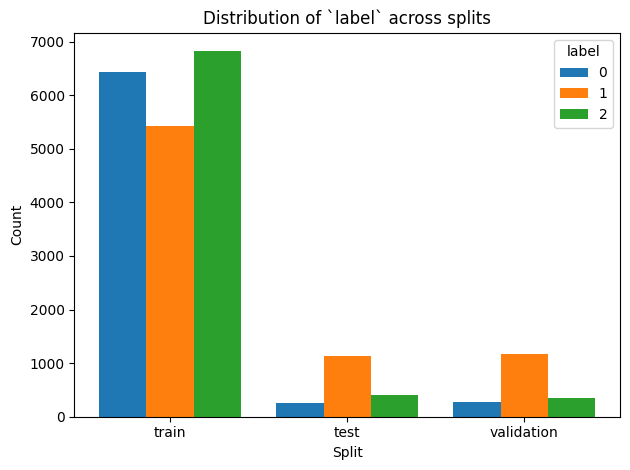

In [18]:
def append_to_train(ds, results):
    new_examples = []
    for res in results:
        label = LABEL2ID.get(MODEL_LABEL_MAPPING.get(res["label"]))
        new_examples.append({"text": res["generated_text"], "label": label})

    new_dataset = Dataset.from_list(new_examples)
    ds["train"] = concatenate_datasets([ds["train"], new_dataset])
    return ds

ds = append_to_train(ds, new_data)

plot_feature_distribution(ds, "label")

In [19]:
output_dir = "ft_sentiment_augmented"

In [20]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL)

In [21]:
def tokenize_function(examples):
    return tokenizer(examples['text'],
                     padding='max_length',
                     truncation=True,
                     max_length=512)

train_dataset = ds['train']
test_dataset = ds['test']
validation_dataset = ds['validation']

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_validation = validation_dataset.map(tokenize_function, batched=True)

tokenized_train = tokenized_train.remove_columns(['text'])
tokenized_test = tokenized_test.remove_columns(['text'])
tokenized_validation = tokenized_validation.remove_columns(['text'])

tokenized_train.set_format('torch')
tokenized_test.set_format('torch')
tokenized_validation.set_format('torch')

Map:   0%|          | 0/18695 [00:00<?, ? examples/s]

Map:   0%|          | 0/1790 [00:00<?, ? examples/s]

Map:   0%|          | 0/1790 [00:00<?, ? examples/s]

In [22]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    precision_weighted = precision_score(labels, predictions, average='weighted')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    
    # Per-class F1 (optional, for analysis)
    f1_per_class = f1_score(labels, predictions, average=None)
    
    return {
        "f1": f1_macro,
        "accuracy": acc,
        "f1_weighted": f1_weighted,
        "precision": precision_weighted,
        "recall": recall_weighted,
        "f1_per_class_0": f1_per_class[0],
        "f1_per_class_1": f1_per_class[1],
        "f1_per_class_2": f1_per_class[2],
    }

In [23]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,  # Further reduce the learning rate
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,  # Continue with fewer epochs due to overfitting
    weight_decay=0.1,  # Increase weight decay to regularize the model
    save_strategy="epoch",
    eval_strategy="epoch",
    push_to_hub=False,
    load_best_model_at_end=True,
    gradient_accumulation_steps=1,  # Accumulate gradients to simulate larger batch sizes
    lr_scheduler_type="linear",  # Use a linear learning rate scheduler
    logging_steps=500,  # Increase logging to monitor training closely
    warmup_steps=500,  # Add a warmup phase to stabilize learning at the start
    gradient_checkpointing=True,  # Enable gradient checkpointing to save memory
    max_grad_norm=1.0,  # Gradient clipping,
    fp16=True,  # enable mixed precision
    dataloader_pin_memory=True,
    dataloader_num_workers=12,
    optim="adamw_torch_fused",
    metric_for_best_model="f1",
    greater_is_better=True,
)

# Early stopping callback with patience of 2 epochs
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Stop training if no improvement after 2 epochs
    early_stopping_threshold=0.01
)

# Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],

)
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,F1,Accuracy,F1 Weighted,Precision,Recall,F1 Per Class 0,F1 Per Class 1,F1 Per Class 2
1,No log,0.467353,0.777558,0.816201,0.821023,0.832636,0.816201,0.676667,0.863033,0.792974
2,0.294800,0.359688,0.818286,0.853631,0.854984,0.857619,0.853631,0.749077,0.893750,0.812030
3,0.294800,0.317761,0.841009,0.874860,0.875766,0.877208,0.874860,0.770398,0.911437,0.841191
4,0.135700,0.365971,0.844042,0.878771,0.878046,0.878122,0.878771,0.774059,0.912758,0.845311
5,0.135700,0.507533,0.827605,0.856425,0.859777,0.872004,0.856425,0.763441,0.893041,0.826334
6,0.076800,0.498641,0.839332,0.872626,0.873212,0.874071,0.872626,0.768031,0.907473,0.842491


TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if poss

TrainOutput(global_step=1758, training_loss=0.1515677797102684, metrics={'train_runtime': 444.3027, 'train_samples_per_second': 420.772, 'train_steps_per_second': 6.595, 'total_flos': 2.951343206654976e+16, 'train_loss': 0.1515677797102684, 'epoch': 6.0})

In [24]:
trainer.model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('ft_sentiment_augmented/tokenizer_config.json',
 'ft_sentiment_augmented/special_tokens_map.json',
 'ft_sentiment_augmented/vocab.json',
 'ft_sentiment_augmented/merges.txt',
 'ft_sentiment_augmented/added_tokens.json',
 'ft_sentiment_augmented/tokenizer.json')

In [25]:
new_model = AutoModelForSequenceClassification.from_pretrained(output_dir)
new_tokenizer = AutoTokenizer.from_pretrained(output_dir)

In [26]:
new_pipe = pipeline(
    "text-classification",
    model=new_model,
    tokenizer=new_tokenizer,
    device=0
)

new_test_evals = evaluate_sentiment_model(new_pipe, ds["test"], "text", "label")

print(new_test_evals)

Device set to use cuda:0


Processed 0 rows: LABEL_1 vs LABEL_1
Processed 1000 rows: LABEL_2 vs LABEL_1
{'accuracy': 0.8793296089385475, 'f1_macro': 0.8450288152136513, 'f1_weighted': 0.8786603941206451, 'precision': 0.8787378353804361, 'recall': 0.8793296089385475, 'confusion_matrix': array([[ 186,   55,   11],
       [  34, 1041,   60],
       [   7,   49,  347]]), 'f1_per_class_0': np.float64(0.7766179540709812), 'f1_per_class_1': np.float64(0.9131578947368421), 'f1_per_class_2': np.float64(0.8453105968331304)}


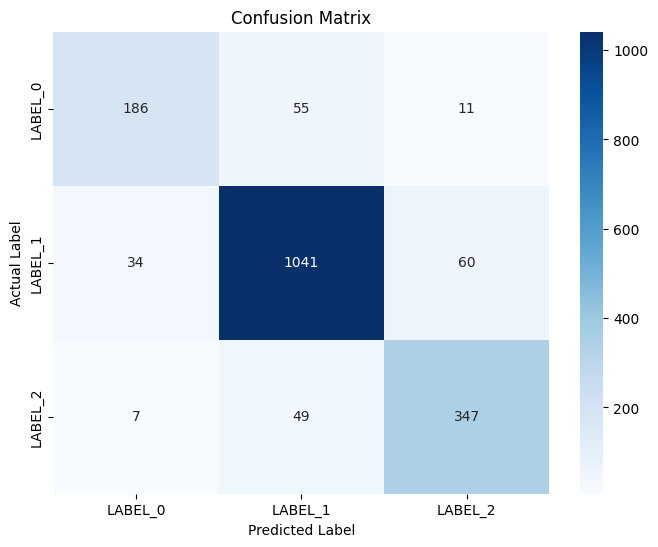

In [27]:
plot_cm(new_test_evals["confusion_matrix"])